In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
import matplotlib.pyplot as plt
from scipy import random
from scipy.stats import multivariate_normal


In [3]:
from tensorflow_probability import distributions as tfd

In [4]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True) 
    return x

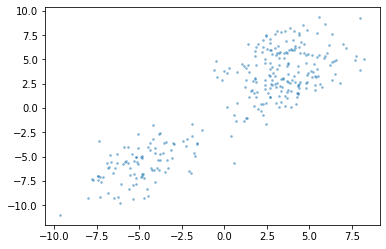

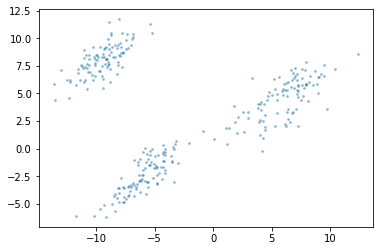

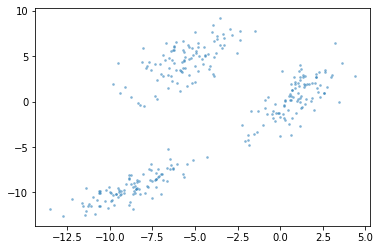

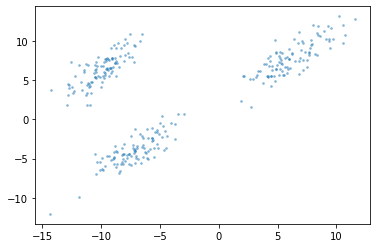

In [5]:
x1 = gen_data(k=3, dim=2, points_per_cluster=100)
x2 = gen_data(k=3, dim=2, points_per_cluster=100)
x3 = gen_data(k=3, dim=2, points_per_cluster=100)
x4 = gen_data(k=3, dim=2, points_per_cluster=100)

In [19]:
mu

<tf.Tensor: shape=(4, 3, 2), dtype=float64, numpy=
array([[[-4.66175776, -5.64242438],
        [ 3.26956484,  3.41357548],
        [ 3.67248193,  4.1564255 ]],

       [[ 6.13925226,  4.66351484],
        [-7.62221944,  3.19108773],
        [-7.57264215,  2.54180519]],

       [[-5.94039414, -2.34320545],
        [-1.52859956,  0.47693709],
        [-2.90853701, -0.92032549]],

       [[ 5.65907659,  7.86501427],
        [-8.75666081,  1.84501204],
        [-8.36209185,  0.34417902]]])>

In [6]:
X=np.array([x1,x2,x3,x4])

In [7]:
x=tf.convert_to_tensor(X,dtype=tf.float64)

In [8]:
x.shape

TensorShape([4, 300, 2])

In [9]:
k=3
d=x.shape[-1]
n=x.shape[1]
b=x.shape[0]

In [10]:
print(k,d,n,b)

3 2 300 4


In [11]:
x.shape

TensorShape([4, 300, 2])

In [12]:
pi=np.ones([b,k])/k
mu=np.random.rand(b,k,d)
sigma=np.ones([b,k,d])
R=np.zeros(shape=(b,n,k))


pi=tf.convert_to_tensor(pi,dtype=tf.float64)
mu=tf.convert_to_tensor(mu,dtype=tf.float64)
sigma=tf.convert_to_tensor(sigma,dtype=tf.float64)
R=tf.convert_to_tensor(R,dtype=tf.float64)

print(pi.shape,mu.shape,sigma.shape,R.shape)

(4, 3) (4, 3, 2) (4, 3, 2) (4, 300, 3)


In [17]:
""" E-step """

x_tmp=tf.expand_dims(x,axis=1) # x.shape==[b,n,d]
x_tmp=tf.tile(x_tmp,[1,k,1,1]) # x_tmp.shape==[b,k,n,d]

mu_tmp=tf.expand_dims(mu,axis=2) # mu.shape==[b,k,d]
mu_tmp=tf.tile(mu_tmp,[1,1,n,1])   # mu_tmp.shape==[b,k,n,d]

sig_tmp=tf.expand_dims(sigma,axis=2) # sigma.shape==[b,k,d]
sig_tmp=tf.tile(sig_tmp,[1,1,n,1])   # sig_tmp.shape == [b,k,n,d]

#print(x_tmp.shape,mu_tmp.shape,sig_tmp.shape)

N = tfd.MultivariateNormalDiag(loc=mu_tmp,scale_diag=sig_tmp).prob(x_tmp)
#print(N.shape)
N = pi[:,:,None]*N
N = N/tf.expand_dims(tf.reduce_sum(N,axis=1),axis=1)
R = tf.transpose(N,perm=[0,2,1])

In [18]:
""" M-step """

# updating pi.
N_k = tf.reduce_sum(R,axis=1)
pi = N_k/n

# updating mu.
mu = tf.matmul(tf.transpose(R,perm=[0,2,1]),x)
mu = mu/N_k[:,:,None]

# updating sigma.

mu_tmp=tf.expand_dims(mu,axis=2)
mu_tmp=tf.tile(mu_tmp,[1,1,n,1])

x_tmp=x_tmp-mu_tmp
x_tmp=tf.square(x_tmp)
#x_tmp_T=tf.transpose(x_tmp,perm=[0,1,2,4,3])
#res = tf.matmul(x_tmp,x_tmp_T)
print(x_tmp.shape)

R_T=tf.transpose(R,perm=[0,2,1])

x_tmp = tf.multiply(tf.reshape(R_T,[b,k,n,1]),x_tmp)
sigma = tf.reduce_sum(x_tmp,axis=2)/tf.reshape(N_k,[b,k,1])
sigma=tf.sqrt(sigma)

(4, 3, 300, 2)


In [ ]:
sigma.shape

TensorShape([4, 3, 2])

In [37]:
tf.reduce_sum(R,axis=2)

<tf.Tensor: shape=(4, 300), dtype=float64, numpy=
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])>